# This is the Saildrone and GOES collocation code.

trying to get mfopendataset to work with opendap data......


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import requests

def get_sat_filename(date):
    dir_sat='https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/'
    syr, smon, sdym = str(date.dt.year.data), str(date.dt.month.data).zfill(2), str(date.dt.day.data).zfill(2)
    sjdy, shr = str(date.dt.dayofyear.data).zfill(2),str(date.dt.hour.data).zfill(2)
    if date.dt.hour.data==0:
        datetem = date - np.timedelta64(1,'D') 
        sjdy = str(datetem.dt.dayofyear.data).zfill(2)
#        syr, smon, sdym = str(datetem.dt.year.data), str(datetem.dt.month.data).zfill(2), str(datetem.dt.day.data).zfill(2)
    fgoes='0000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_'
    dstr=syr+smon+sdym+shr
    dstr2=syr+smon+sdym+'_'+shr
    sat_filename=dir_sat+syr+'/'+sjdy+'/'+ dstr + fgoes +dstr2+'0000-v02.0-fv01.0.nc'   
    r = requests.get(sat_filename)
    if r.status_code != requests.codes.ok:
        exists = False
    else:
        exists = True
    print(exists,sat_filename)
    return sat_filename, exists


# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.

There are 6 NaN values in the lat/lon data arrays, interpolate across these

We want to collocate with wind vectors for this example,  but the wind vectors are only every 10 minutes rather than every minute, so use .dropna to remove all values in the dataset from all dataarrays when wind vectors aren't availalbe

In [22]:
filename_collocation_data = 'F:/data/cruise_data/saildrone/baja-2018/ccmp_collocation_data.nc'
#filename_usv = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv = xr.open_dataset(filename_usv)
ds_usv.close()
ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv = ds_usv.sel(time=slice('2018-04-11T18:30',ds_usv.time[-1].data))  #first part of data is when USV being towed, elminiate
ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
ds_usv_subset = ds_usv.copy(deep=True)
#ds_usv_subset = ds_usv.dropna(dim='time',subset={'UWND_MEAN'})   #get rid of all the nan
#print(ds_usv_subset.UWND_MEAN[2000:2010].values)

In order to use open_mfdataset you need to either provide a path or a list of filenames to input

Here we use the USV cruise start and end date to read in all data for that period

In [23]:
read_date,end_date = ds_usv_subset.time.min(),ds_usv_subset.time.max()
filelist = []
while read_date<=(end_date+np.timedelta64(1,'h')):
#while read_date<=(ds_usv_subset.time.min()+np.timedelta64(10,'h')):
    tem_filename,exists = get_sat_filename(read_date)
    if exists:
        filelist.append(tem_filename)
    read_date=read_date+np.timedelta64(1,'h')
print(filelist[0])

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/101/20180411180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180411_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/101/20180411190000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180411_190000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/101/20180411200000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180411_200000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/101/20180411210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180411_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/101/20180411220000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/103/20180413090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180413_090000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/103/20180413100000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180413_100000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/103/20180413110000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180413_110000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/103/20180413120000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180413_120000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/103/20180413130000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/104/20180415000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180415_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/105/20180415010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180415_010000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/105/20180415020000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180415_020000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/105/20180415030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180415_030000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/105/20180415040000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/106/20180416150000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180416_150000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/106/20180416160000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180416_160000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/106/20180416170000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180416_170000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/106/20180416180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180416_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/106/20180416190000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/108/20180418060000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180418_060000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/108/20180418070000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180418_070000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/108/20180418080000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180418_080000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/108/20180418090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180418_090000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/108/20180418100000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/109/20180419210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180419_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/109/20180419220000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180419_220000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/109/20180419230000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180419_230000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/109/20180420000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180420_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/110/20180420010000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/111/20180421120000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180421_120000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/111/20180421130000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180421_130000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/111/20180421140000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180421_140000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/111/20180421150000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180421_150000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/111/20180421160000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/113/20180423030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180423_030000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/113/20180423040000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180423_040000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/113/20180423050000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180423_050000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/113/20180423060000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180423_060000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/113/20180423070000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/114/20180424180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180424_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/114/20180424190000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180424_190000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/114/20180424200000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180424_200000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/114/20180424210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180424_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/114/20180424220000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/116/20180426090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180426_090000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/116/20180426100000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180426_100000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/116/20180426110000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180426_110000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/116/20180426120000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180426_120000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/116/20180426130000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/117/20180428000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180428_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/118/20180428010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180428_010000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/118/20180428020000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180428_020000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/118/20180428030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180428_030000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/118/20180428040000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/119/20180429150000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180429_150000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/119/20180429160000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180429_160000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/119/20180429170000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180429_170000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/119/20180429180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180429_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/119/20180429190000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/121/20180501060000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180501_060000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/121/20180501070000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180501_070000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/121/20180501080000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180501_080000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/121/20180501090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180501_090000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/121/20180501100000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/122/20180502210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180502_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/122/20180502220000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180502_220000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/122/20180502230000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180502_230000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/122/20180503000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180503_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/123/20180503010000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/124/20180504120000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180504_120000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/124/20180504130000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180504_130000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/124/20180504140000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180504_140000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/124/20180504150000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180504_150000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/124/20180504160000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/126/20180506030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180506_030000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/126/20180506040000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180506_040000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/126/20180506050000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180506_050000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/126/20180506060000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180506_060000-v02.0-fv01.0.nc
False https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/126/20180506070000-OSISAF-L3C_GHRSST-SST

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/127/20180507180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180507_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/127/20180507190000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180507_190000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/127/20180507200000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180507_200000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/127/20180507210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180507_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/127/20180507220000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/129/20180509090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180509_090000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/129/20180509100000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180509_100000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/129/20180509110000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180509_110000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/129/20180509120000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180509_120000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/129/20180509130000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/130/20180511000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180511_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/131/20180511010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180511_010000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/131/20180511020000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180511_020000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/131/20180511030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180511_030000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/131/20180511040000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/132/20180512150000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180512_150000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/132/20180512160000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180512_160000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/132/20180512170000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180512_170000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/132/20180512180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180512_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/132/20180512190000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/134/20180514060000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180514_060000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/134/20180514070000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180514_070000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/134/20180514080000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180514_080000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/134/20180514090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180514_090000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/134/20180514100000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/135/20180515210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180515_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/135/20180515220000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180515_220000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/135/20180515230000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180515_230000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/135/20180516000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180516_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/136/20180516010000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/137/20180517120000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180517_120000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/137/20180517130000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180517_130000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/137/20180517140000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180517_140000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/137/20180517150000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180517_150000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/137/20180517160000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/139/20180519030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180519_030000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/139/20180519040000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180519_040000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/139/20180519050000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180519_050000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/139/20180519060000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180519_060000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/139/20180519070000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/140/20180520180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180520_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/140/20180520190000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180520_190000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/140/20180520200000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180520_200000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/140/20180520210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180520_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/140/20180520220000-OSISAF-L3C_GHRSST-SSTs

False https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/142/20180522090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180522_090000-v02.0-fv01.0.nc
False https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/142/20180522100000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180522_100000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/142/20180522110000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180522_110000-v02.0-fv01.0.nc
False https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/142/20180522120000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180522_120000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/142/20180522130000-OSISAF-L3C_GHRSST-S

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/143/20180524000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180524_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/144/20180524010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180524_010000-v02.0-fv01.0.nc
False https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/144/20180524020000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180524_020000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/144/20180524030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180524_030000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/144/20180524040000-OSISAF-L3C_GHRSST-SST

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/145/20180525150000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180525_150000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/145/20180525160000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180525_160000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/145/20180525170000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180525_170000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/145/20180525180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180525_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/145/20180525190000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/147/20180527060000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180527_060000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/147/20180527070000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180527_070000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/147/20180527080000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180527_080000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/147/20180527090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180527_090000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/147/20180527100000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/148/20180528210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180528_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/148/20180528220000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180528_220000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/148/20180528230000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180528_230000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/148/20180529000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180529_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/149/20180529010000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/150/20180530120000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180530_120000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/150/20180530130000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180530_130000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/150/20180530140000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180530_140000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/150/20180530150000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180530_150000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/150/20180530160000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/152/20180601030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180601_030000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/152/20180601040000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180601_040000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/152/20180601050000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180601_050000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/152/20180601060000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180601_060000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/152/20180601070000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/153/20180602180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180602_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/153/20180602190000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180602_190000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/153/20180602200000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180602_200000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/153/20180602210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180602_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/153/20180602220000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/155/20180604090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180604_090000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/155/20180604100000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180604_100000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/155/20180604110000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180604_110000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/155/20180604120000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180604_120000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/155/20180604130000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/156/20180606000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180606_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/157/20180606010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180606_010000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/157/20180606020000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180606_020000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/157/20180606030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180606_030000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/157/20180606040000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/158/20180607150000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180607_150000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/158/20180607160000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180607_160000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/158/20180607170000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180607_170000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/158/20180607180000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180607_180000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/158/20180607190000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/160/20180609060000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180609_060000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/160/20180609070000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180609_070000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/160/20180609080000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180609_080000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/160/20180609090000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180609_090000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/160/20180609100000-OSISAF-L3C_GHRSST-SSTs

True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/161/20180610210000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180610_210000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/161/20180610220000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180610_220000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/161/20180610230000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180610_230000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/161/20180611000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180611_000000-v02.0-fv01.0.nc
True https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/162/20180611010000-OSISAF-L3C_GHRSST-SSTs

# Read in MUR data
Read in data using open_mfdataset with the option coords='minimal'

The dataset is printed out and you can see that rather than straight xarray data array for each of the data variables open_mfdataset using dask arrays

In [24]:
ds_sat = xr.open_mfdataset(filelist,coords='minimal')
ds_sat

OSError: [Errno -37] NetCDF: Write to read only: b'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3C/AMERICAS/GOES16/OSISAF/v1/2018/102/20180412200000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20180412_200000-v02.0-fv01.0.nc'

# Xarray interpolation won't run on chunked dimensions.  
1. First let's subset the data to make it smaller to deal with by using the cruise lat/lons

1. Now load the data into memory (de-Dask-ify) it  


In [ ]:
#Step 1 from above
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data))
#Step 2 from above
subset.load()
#now collocate with usv lat and lons
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')


# A larger STD that isn't reflective of uncertainty in the observation
The collocation above will result in multiple USV data points matched with a single satellite
observation.    The USV is sampling every 1 min and approximately few meters, while the satellite
is an average over a footprint that is interpolated onto a daily mean map.  While calculating the mean would results in a valid mean, the STD would be higher and consist of a component that reflects the uncertainty of the USV and the satellite and a component that reflects the natural variability in the region that is sampled by the USV

Below we use the 'nearest' collocation results to identify when multiple USV data are collcated to
a single satellite observation.
This code goes through the data and creates averages of the USV data that match the single CCMP collocated value.


In [ ]:
ds_tem.dims['time']

In [ ]:
index=302
ds_tem = ds_collocated_nearest.copy(deep=True)
ds_tem_subset = ds_tem.analysed_sst[index:index+1000]
cond = ((ds_tem_subset==ds_collocated_nearest.analysed_sst[index]))
notcond = np.logical_not(cond)
#cond = np.append(np.full(index,True),cond)
#cond = np.append(cond,np.full(ilen-index-1000,True))
#cond.shape
print(cond[0:5].data)
print(ds_tem.analysed_sst[index:index+5].data)
ds_tem.analysed_sst[index:index+1000]=ds_tem.analysed_sst.where(notcond)
print(ds_tem.analysed_sst[index:index+5].data)

In [ ]:
print(ds_collocated_nearest.analysed_sst[300:310].data)
print(ds_collocated_nearest.time.dt.day[300:310].data)
index=302
ilen = ds_tem.dims['time']
#cond = ((ds_tem.analysed_sst[index:index+1000]==ds_collocated_nearest.analysed_sst[index]) 
#            & (ds_tem.time.dt.day[index:index+1000]==ds_collocated_nearest.time.dt.day[index])
#            & (ds_tem.time.dt.hour[index:index+1000]==ds_collocated_nearest.time.dt.hour[index]))
cond = ((ds_tem.analysed_sst[index:index+1000]==ds_collocated_nearest.analysed_sst[index])) 
#cond = np.append(np.full(index,True),cond)
#cond = np.append(cond,np.full(ilen-index-1000,True))
print(cond[index:index+10].data)
print(np.logical_not(cond[index+10]).data)
masked_usv = ds_usv_subset.where(cond,drop=True)


In [ ]:
#ds_collocated_nearest
#print(ds_collocated_nearest.uwnd[244:315].data)
#print(masked_usv.UWND_MEAN[244:315].data)
#print(masked_usv.UWND_MEAN[244:315].mean().data)
#print(masked_usv.time.min().data)
#print(masked_usv.time.max().data)
#print(masked_usv.lon.min().data)
#print(masked_usv.lon.max().data)
#print(masked_usv.time[0].data,masked_usv.time[-1].data)

In [ ]:
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu, duv1, duv2, dlat, dlon, dut = [],[],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.analysed_sst[index]):
        continue
    if np.isnan(ds_tem.analysed_sst[index]):
        continue
   # print(index, ilen)
    iend = index + 1000
    if iend > ilen-1:
        iend = ilen-1
    ds_tem_subset = ds_tem.analysed_sst[index:iend]
    ds_usv_subset2sst = ds_usv_subset.TEMP_CTD_MEAN[index:iend]
    ds_usv_subset2uwnd = ds_usv_subset.UWND_MEAN[index:iend]
    ds_usv_subset2vwnd = ds_usv_subset.VWND_MEAN[index:iend]
    ds_usv_subset2lat = ds_usv_subset.lat[index:iend]
    ds_usv_subset2lon = ds_usv_subset.lon[index:iend]
    ds_usv_subset2time = ds_usv_subset.time[index:iend]
    cond = ((ds_tem_subset==ds_collocated_nearest.analysed_sst[index]))
    notcond = np.logical_not(cond)
    #cond = ((ds_tem.analysed_sst==ds_collocated_nearest.analysed_sst[index]))
    #notcond = np.logical_not(cond)
    masked = ds_tem_subset.where(cond)
    if masked.sum().data==0:  #don't do if data not found
        continue
    masked_usvsst = ds_usv_subset2sst.where(cond,drop=True)
    masked_usvuwnd = ds_usv_subset2uwnd.where(cond,drop=True)
    masked_usvvwnd = ds_usv_subset2vwnd.where(cond,drop=True)
    masked_usvlat = ds_usv_subset2lat.where(cond,drop=True)
    masked_usvlon = ds_usv_subset2lon.where(cond,drop=True)
    masked_usvtime = ds_usv_subset2time.where(cond,drop=True)
    duu=np.append(duu,masked_usvsst.mean().data)
    duv1=np.append(duv1,masked_usvuwnd.mean().data)
    duv2=np.append(duv2,masked_usvvwnd.mean().data)
    dlat=np.append(dlat,masked_usvlat.mean().data)
    dlon=np.append(dlon,masked_usvlon.mean().data)
    tdif = masked_usvtime[-1].data-masked_usvtime[0].data
    mtime=masked_usvtime[0].data+np.timedelta64(tdif/2,'ns')
    dut=np.append(dut,mtime)
    ds_tem.analysed_sst[index:iend]=ds_tem.analysed_sst.where(notcond)
#    ds_tem=ds_tem.where(notcond,np.nan)  #masked used values by setting to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new=xr.Dataset(data_vars={'sst_usv': ('time',duu),'uwnd_usv': ('time',duv1),'vwnd_usv': ('time',duv2),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/goes_downsampled_usv_data2.nc')

In [126]:
ds_new=xr.Dataset(data_vars={'sst_usv': ('time',duu),'uwnd_usv': ('time',duv1),'vwnd_usv': ('time',duv2),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/goes_downsampled_usv_data2.nc')

# redo the collocation
Now, redo the collocation, using 'linear' interpolation using the averaged data.  This will interpolate the data temporally onto the USV sampling which has been averaged to the satellite data grid points

In [127]:
ds_collocated_averaged = subset.interp(lat=ds_new.lat,lon=ds_new.lon,time=ds_new.time,method='linear')
ds_collocated_averaged

<xarray.Dataset>
Dimensions:           (time: 6075)
Coordinates:
    lat               (time) float64 37.81 37.81 37.81 ... 37.78 37.77 37.77
    lon               (time) float64 -122.5 -122.5 -122.5 ... -122.3 -122.3
  * time              (time) datetime64[ns] 2018-04-11T18:53:30 ... 2018-06-11T00:02:00
Data variables:
    analysed_sst      (time) float64 286.3 286.3 286.3 286.3 ... nan nan nan
    analysis_error    (time) float64 0.3899 0.3884 0.3865 0.3858 ... nan nan nan
    mask              (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.009 1.464 1.447
    sea_ice_fraction  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                

In [128]:
ds_collocated_averaged.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/mur_downsampled_collocated_usv_data2.nc')


mean,std dif  [array(0.30333356), array(0.43356769), 6056]
no low wind mean,std dif  [array(0.30803558), array(0.43056361), array(5591)]


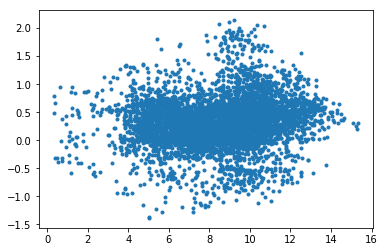

In [138]:
sat_sst = ds_collocated_averaged.analysed_sst[:-19]-273.15
usv_sst = ds_new.sst_usv[:-19]
ds_new['spd']=np.sqrt(ds_new.uwnd_usv**2+ds_new.vwnd_usv**2)
usv_spd = ds_new.spd[:-19]
dif_sst = sat_sst - usv_sst
print('mean,std dif ',[dif_sst.mean().data,dif_sst.std().data,dif_sst.shape[0]])
plt.plot(usv_spd,dif_sst,'.')
sat_sst = ds_collocated_averaged.analysed_sst[:-19]-273.15
usv_sst = ds_new.sst_usv[:-19]
dif_sst = sat_sst - usv_sst
cond = usv_spd>2
dif_sst = dif_sst.where(cond)
print('no low wind mean,std dif ',[dif_sst.mean().data,dif_sst.std().data,sum(cond).data])



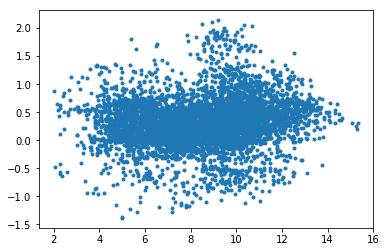

In [137]:
plt.plot(usv_spd,dif_sst,'.')

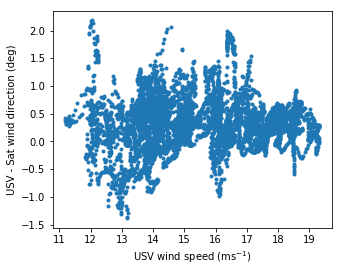

In [96]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(sat_sst,sat_sst-usv_sst,'.')
ax.set_xlabel('USV wind speed (ms$^{-1}$)')
ax.set_ylabel('USV - Sat wind direction (deg)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_sst_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


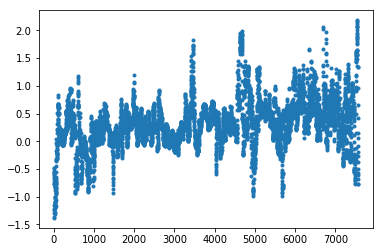

In [94]:
plt.plot(dif_sst[:-19],'.')

In [ ]:
#faster not sure why
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu,dvu, dlat, dlon, dut = [],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.uwnd[index]):
        continue
    test = ds_collocated_nearest.where((ds_tem.uwnd==ds_collocated_nearest.uwnd[index])&(ds_tem.vwnd==ds_collocated_nearest.vwnd[index]))
    test = test/test
    if test.uwnd.sum()>0:
        duu=np.append(duu,(ds_usv_subset.UWND_MEAN*test.uwnd).mean().data)
        dvu=np.append(dvu,(ds_usv_subset.VWND_MEAN*test.vwnd).mean().data)
        dlat=np.append(dlat,(ds_usv_subset.lat*test.lat).mean().data)
        dlon=np.append(dlon,(ds_usv_subset.lon*test.lon).mean().data)
        tdif = ds_usv_subset.time.where(test.vwnd==1).max().data-ds_usv_subset.time.where(test.vwnd==1).min().data
        mtime=ds_usv_subset.time.where(test.vwnd==1).min().data+np.timedelta64(tdif/2,'ns')
        dut=np.append(dut,mtime)
        ds_tem=ds_tem.where(np.isnan(test),np.nan)  #you have used values, so set to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new2=xr.Dataset(data_vars={'u_usv': ('time',duu),
                             'v_usv': ('time',dvu),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})


In [ ]:
#testing code above
ds_tem = ds_collocated_nearest.copy(deep=True)
print(ds_collocated_nearest.uwnd[1055].data)
print(ds_collocated_nearest.uwnd[1050:1150].data)
test = ds_collocated_nearest.where((ds_collocated_nearest.uwnd==ds_collocated_nearest.uwnd[1055])&(ds_collocated_nearest.vwnd==ds_collocated_nearest.vwnd[1055]))
test = test/test
print(test.uwnd[1050:1150].data)
ds_tem=ds_tem.where(np.isnan(test),np.nan)
print(ds_tem.uwnd[1050:1150].data)
print((ds_usv_subset.UWND_MEAN*test.uwnd).mean())
print((ds_usv_subset.VWND_MEAN*test.vwnd).mean())


In [ ]:
from scipy.interpolate import griddata
# interpolate
points = (ds_usv_subset.lon.data,ds_usv_subset.lat.data)
grid_in_lon,grid_in_lat = np.meshgrid(subset.lon.data,subset.lat.data)
grid_in = (grid_in_lon,grid_in_lat)
values = ds_usv_subset.UWND_MEAN.data
#print(points.size)
zi = griddata(points,values,grid_in,method='linear',fill_value=np.nan)
zi2 = griddata(points,values/values,grid_in,method='linear',fill_value=np.nan)
print(np.isfinite(zi).sum())

In [ ]:
plt.pcolormesh(subset.lon,subset.lat,zi,vmin=-5,vmax=5)
plt.plot(ds_usv_subset.lon,ds_usv_subset.lat,'.')
#plt.contourf(subset.uwnd[0,:,:])

In [ ]:
len(points[0])

In [ ]:
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

THRESHOLD=1
# Construct kd-tree, functionality copied from scipy.interpolate
tree = cKDTree(points)
xi = _ndim_coords_from_arrays(grid_in, ndim=len(points[0]))
dists, indexes = tree.query(xi)

# Copy original result but mask missing values with NaNs
result3 = result2[:]
result3[dists > THRESHOLD] = np.nan

# Show
plt.figimage(result3)
plt.show()

In [ ]:
#testing
index=300
ds_tem = ds_collocated_nearest.copy(deep=True)
cond = ((ds_tem.uwnd==ds_collocated_nearest.uwnd[index]) & (ds_tem.vwnd==ds_collocated_nearest.vwnd[index]))
notcond = ((ds_tem.uwnd!=ds_collocated_nearest.uwnd[index]) & (ds_tem.vwnd!=ds_collocated_nearest.vwnd[index]))
masked = ds_tem.where(cond)
masked_usv = ds_usv_subset.where(cond,drop=True)
print(masked.uwnd.sum().data)
#print(masked.nobs[290:310].data)
print((masked_usv.UWND_MEAN).mean().data)
print(ds_tem.uwnd[243:316])
ds_tem=ds_tem.where(notcond,np.nan)  #you have used values, so set to nan
print(ds_tem.uwnd[243:316])


In [ ]:
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu, duv1, duv2, dlat, dlon, dut = [],[],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.analysed_sst[index]):
        continue
    if np.isnan(ds_tem.analysed_sst[index]):
        continue
    print(index, ilen)
    cond = ((ds_tem.analysed_sst==ds_collocated_nearest.analysed_sst[index]) 
            & (ds_tem.time.dt.day==ds_collocated_nearest.time.dt.day[index])
            & (ds_tem.time.dt.hour==ds_collocated_nearest.time.dt.hour[index]))
    notcond = np.logical_not(cond)
    masked = ds_tem.where(cond)
    masked_usv = ds_usv_subset.where(cond,drop=True)
    if masked.analysed_sst.sum().data==0:  #don't do if data not found
        continue
    duu=np.append(duu,masked_usv.TEMP_CTD_MEAN.mean().data)
    duv1=np.append(duu,masked_usv.UWND_MEAN.mean().data)
    duv2=np.append(duu,masked_usv.VWND_MEAN.mean().data)
    dlat=np.append(dlat,masked_usv.lat.mean().data)
    dlon=np.append(dlon,masked_usv.lon.mean().data)
    tdif = masked_usv.time[-1].data-masked_usv.time[0].data
    mtime=masked_usv.time[0].data+np.timedelta64(tdif/2,'ns')
    dut=np.append(dut,mtime)
    ds_tem=ds_tem.where(notcond,np.nan)  #masked used values by setting to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new=xr.Dataset(data_vars={'sst_usv': ('time',duu),'uwnd_usv': ('time',duv1),'vwnd_usv': ('time',duv2),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/mur_downsampled_usv_data.nc')